In [ ]:
# Install if needed (PyTorch trên Colab có sẵn rồi)
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
from torch.cuda.amp import GradScaler, autocast
import os


In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Transform
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Using device: cuda


In [ ]:
# Load pretrained EfficientNetV2-Small
model = timm.create_model('efficientnetv2_s', pretrained=False)

# Sửa output 10 classes CIFAR-10
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 10)
)

model = model.to(device)


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# AMP
scaler = GradScaler()

<ipython-input-12-14e6bd8d16b0>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Train
def train(epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():  # Mixed Precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"[Epoch {epoch}] Training Loss: {running_loss/len(train_loader):.4f}")

# Test
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100.0 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [ ]:
best_acc = 0

for epoch in range(1, 31):  # Train 30 epochs
    train(epoch)
    acc = test()
    scheduler.step()

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved Best Model - Accuracy: {best_acc:.2f}%")


<ipython-input-13-67c02b809b1e>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


[Epoch 1] Training Loss: 1.6655
Test Accuracy: 49.50%
✅ Saved Best Model - Accuracy: 49.50%
[Epoch 2] Training Loss: 1.1734
Test Accuracy: 64.95%
✅ Saved Best Model - Accuracy: 64.95%
[Epoch 3] Training Loss: 0.9065
Test Accuracy: 72.32%
✅ Saved Best Model - Accuracy: 72.32%
[Epoch 4] Training Loss: 0.7258
Test Accuracy: 77.32%
✅ Saved Best Model - Accuracy: 77.32%
[Epoch 5] Training Loss: 0.6015
Test Accuracy: 79.47%
✅ Saved Best Model - Accuracy: 79.47%
[Epoch 6] Training Loss: 0.5176
Test Accuracy: 82.35%
✅ Saved Best Model - Accuracy: 82.35%
[Epoch 7] Training Loss: 0.4519
Test Accuracy: 83.46%
✅ Saved Best Model - Accuracy: 83.46%
[Epoch 8] Training Loss: 0.3887
Test Accuracy: 84.87%
✅ Saved Best Model - Accuracy: 84.87%
[Epoch 9] Training Loss: 0.3445
Test Accuracy: 86.07%
✅ Saved Best Model - Accuracy: 86.07%
[Epoch 10] Training Loss: 0.3020
Test Accuracy: 86.29%
✅ Saved Best Model - Accuracy: 86.29%
[Epoch 11] Training Loss: 0.2611
Test Accuracy: 87.19%
✅ Saved Best Model - Acc

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)

# Đánh giá lần cuối
final_acc = test()
print(f"🔥 Final Best Accuracy: {final_acc:.2f}%")

Test Accuracy: 89.61%
🔥 Final Best Accuracy: 89.61%


In [ ]:
# Load best model từ file
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
print("✅ Loaded Best Model from Disk")

✅ Loaded Best Model from Disk


In [ ]:
# Đánh giá lại
final_acc = test()
print(f"🔥 Final Test Accuracy on CIFAR-10: {final_acc:.2f}%")

Test Accuracy: 89.61%
🔥 Final Test Accuracy on CIFAR-10: 89.61%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names trong CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Hàm Predict ngẫu nhiên 1 ảnh
def predict_random_image():
    model.eval()

    # Random 1 ảnh từ test_dataset
    idx = np.random.randint(0, len(test_dataset))
    image, label = test_dataset[idx]

    # Hiển thị ảnh
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)) * 0.5 + 0.5)  # unnormalize
    plt.axis('off')
    plt.title(f"True Label: {classes[label]}")
    plt.show()

    # Predict
    image = image.unsqueeze(0).to(device)  # thêm batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    print(f"🎯 Predicted: {classes[predicted.item()]}")


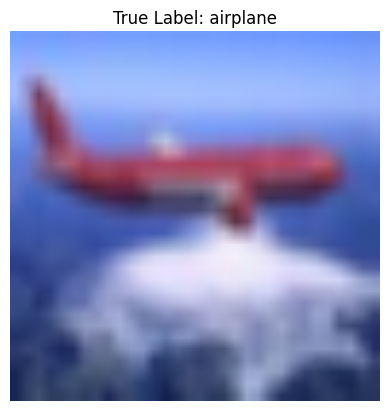

🎯 Predicted: airplane


In [ ]:
predict_random_image()

In [ ]:
def plot_training_history():
    min_len = min(len(train_losses), len(test_accuracies))
    epochs = range(1, min_len + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses[:min_len], 'r-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, test_accuracies[:min_len], 'b-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()

    plt.show()


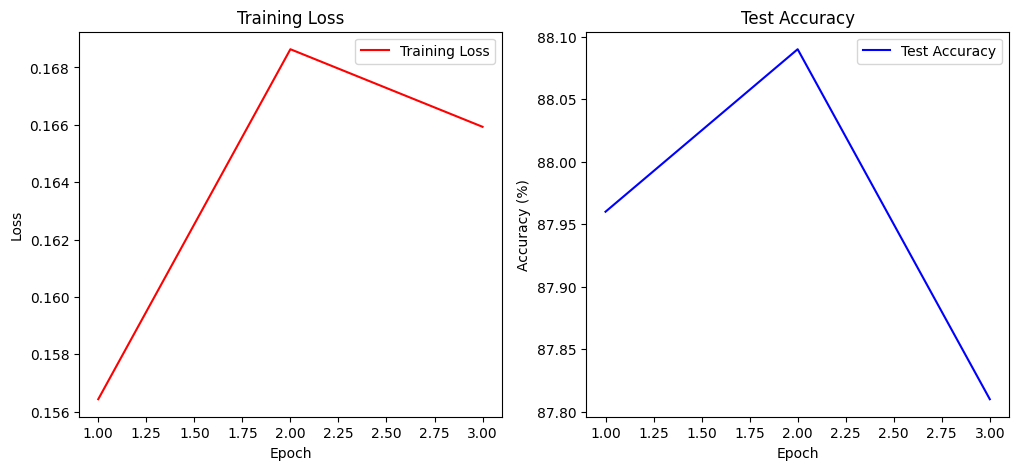

In [ ]:
# Gọi vẽ
plot_training_history()